In [27]:
# Constants
random_state = 57

In [28]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time, sys

### Gradient boosting Challenge

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

Lower the error rates, based on your model in the training set.

### From the Example and challenge

In [29]:
file = 'ESSdata_Thinkful.csv'
path = path="../../../../Datafiles/"
df = pd.read_csv((path+file)).dropna()

print("there are {} entries in the data file {}".format(len(df), file))

there are 8147 entries in the data file ESSdata_Thinkful.csv


In [30]:
df.head(5)

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


Columns used in the dataset: 

| Column Name | Definition | Status |
|-------------|--------------|-------|
|partner|Lives with partner: values 1 lives with partner, 2 does not.| Dependent|
|cntry|Country|Not used in model | Independent |
|idno|ID number| Not used in model | Independent |
|ppltrst|Most people can be trusted: 0 can't trust, 10 very trusing| Independent |
|pplfair|Most people try to take advantage of you| Independent |
|plhlp|Most of the time people are helpful| Independent |
|happy|How happy are you| Independent |
|sclmeet|How often do you socially meet with friends, relatives, colleagues| Independent |
|sclact|Take part in social activities| Independent |
|gndr|Gender| Independent |
|agea|Age of appliant| Independent |


In [31]:
# Let's add some new features...

df['partner'] = np.where(df['partner'] == 2, 0, 1) # Set it to 0=Nopartner, 1=partner
df['age55_happy'] = (df['agea'] * df['happy']) # A new feature here -> Filter
df['happy_squared'] = df['happy'] ** 2 # new feature

In [32]:
# Definine outcome and predictors.
print("the current time of start is {}".format(str(datetime.datetime.now())))

y = df['partner']
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
# X = df[['agea', 'pplhlp', 'happy', 'tvtot', 'pplfair', 'ppltrst', 'sclmeet','sclact','gndr']] # these were the most significant
# X = df.loc[:,  df.columns.isin(['agea', 'happy'])]
X = df[['agea','happy', 'sclmeet',  'tvtot', 'pplhlp', 'gndr', 'pplfair','ppltrst','sclact', 'age55_happy','happy_squared']] # added new feature age55_happy

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

#countries ,'ES', 'CH', 'CZ','NO','SE','DE'

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]
print("the current time of end is {}".format(str(datetime.datetime.now())))

the current time of start is 2019-05-23 23:33:13.199547
the current time of end is 2019-05-23 23:33:13.206243


In [33]:
X.head(20)

,agea,happy,sclmeet,tvtot,pplhlp,gndr,pplfair,ppltrst,sclact,age55_happy,happy_squared,CH,CZ,DE,ES,NO,SE
0,60.0,8.0,5.0,3.0,5.0,2.0,10.0,3.0,4.0,480.0,64.0,1,0,0,0,0,0
1,59.0,9.0,3.0,6.0,5.0,2.0,7.0,5.0,2.0,531.0,81.0,1,0,0,0,0,0
2,24.0,7.0,6.0,1.0,8.0,1.0,8.0,8.0,3.0,168.0,49.0,1,0,0,0,0,0
3,64.0,10.0,6.0,4.0,7.0,2.0,6.0,6.0,2.0,640.0,100.0,1,0,0,0,0,0
4,55.0,8.0,7.0,5.0,5.0,2.0,7.0,6.0,2.0,440.0,64.0,1,0,0,0,0,0
6,76.0,0.0,2.0,3.0,2.0,1.0,5.0,0.0,2.0,0.0,0.0,1,0,0,0,0,0
7,30.0,10.0,5.0,2.0,3.0,2.0,5.0,4.0,2.0,300.0,100.0,1,0,0,0,0,0
8,84.0,9.0,6.0,2.0,8.0,2.0,8.0,8.0,4.0,756.0,81.0,1,0,0,0,0,0
9,62.0,7.0,4.0,4.0,8.0,2.0,4.0,4.0,2.0,434.0,49.0,1,0,0,0,0,0
10,33.0,9.0,5.0,1.0,7.0,2.0,7.0,6.0,2.0,297.0,81.0,1,0,0,0,0,0


In [34]:
# We'll make 50 iterations, use 2-deep trees, and set our loss function.
min_value = 2
max_value = 100
loss_function = 'deviance'

print("\n{} We are testing with varying max_leaf_nodes and min_samples_leaf between {} and {},\nwith the loss_function={}.".format(str(datetime.datetime.now()),
                                                                                                                                   min_value, 
                                                                                                                                   max_value,
                                                                                                                                   loss_function))
loss_functions = ['deviance', 'exponential']
for loss_function in loss_functions:
    print("\nWorking on loss_function:{}\n\n\n".format(loss_function))
    lowest_train_tI_errors = (-1,1000)
    lowest_train_tII_errors =(-1,1000)
    lowest_test_tI_errors = (-1,1000)
    lowest_test_tII_errors = (-1,1000)
    tr_tI = 0
    tr_tII = 0
    te_tI = 0
    te_tII = 0
    
    for depth_value in range(2,max_value):
        params = {'n_estimators': 500,
                  'max_depth': 8,
                  'loss': loss_function,
                  'max_leaf_nodes': depth_value, # 8 worked best...
                  'min_samples_leaf': depth_value * 3
                  ,'random_state' : random_state
                 }

        # Initialize and fit the model.
        clf = ensemble.GradientBoostingClassifier(**params)
        clf.fit(X_train, y_train)

        predict_train = clf.predict(X_train)
        predict_test = clf.predict(X_test)

        # Accuracy tables.
        table_train = pd.crosstab(y_train, predict_train, margins=True)
        table_test = pd.crosstab(y_test, predict_test, margins=True)

        train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
        train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

        if pd.to_numeric(train_tI_errors) < lowest_train_tI_errors[1]:

            tr_tI = 1

        if pd.to_numeric(train_tII_errors) < lowest_train_tII_errors[1]:
            tr_tII = 1

        if tr_tI == 1 or tr_tII == 1:
            lowest_train_tI_errors = (depth_value,pd.to_numeric(train_tI_errors))
            lowest_train_tII_errors = (depth_value,pd.to_numeric(train_tII_errors))
            tr_tI = 0 
            tr_tII = 0

        test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
        test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

        if pd.to_numeric(test_tI_errors) < lowest_test_tI_errors[1]:
            te_tI = 1

        if pd.to_numeric(test_tII_errors) < lowest_test_tII_errors[1]:
            te_tII = 1

        if te_tI == 1 or te_tII == 1:
            lowest_test_tI_errors = (depth_value,pd.to_numeric(test_tI_errors))
            lowest_test_tII_errors = (depth_value,pd.to_numeric(test_tII_errors))
            te_tI = 0
            te_tII = 0


    print("\nHere are the summary findings.")
    print("loss_function={}, Lowest train_tI_Errors={}, found in max_leaf_nodes={}".format( loss_function,
                                                                                            lowest_train_tI_errors[1],
                                                                                            lowest_train_tI_errors[0]))
    print("loss_function={}, Lowest train_tII_Errors={}, found in max_leaf_nodes={}".format(loss_function,
                                                                                            lowest_train_tII_errors[1],
                                                                                            lowest_train_tII_errors[0]))

    print("loss_function={}, Lowest test_tI_Errors={}, found in max_leaf_nodes={}".format( loss_function,
                                                                                           lowest_test_tI_errors[1],
                                                                                           lowest_test_tI_errors[0]))
    print("loss_function={}, Lowest test_tII_Errors={}, found in max_leaf_nodes={}".format(loss_function,
                                                                                           lowest_test_tII_errors[1],
                                                                                           lowest_test_tII_errors[0]))
    print("\n{} We finished testing at.".format(str(datetime.datetime.now())))


2019-05-23 23:33:13.305771 We are testing with varying max_leaf_nodes and min_samples_leaf between 2 and 100,
with the loss_function=deviance.

Working on loss_function:deviance




Here are the summary findings.
loss_function=deviance, Lowest train_tI_Errors=0.08851609383524277, found in max_leaf_nodes=35
loss_function=deviance, Lowest train_tII_Errors=0.020731042007637753, found in max_leaf_nodes=35
loss_function=deviance, Lowest test_tI_Errors=0.18036809815950922, found in max_leaf_nodes=98
loss_function=deviance, Lowest test_tII_Errors=0.08220858895705521, found in max_leaf_nodes=98

2019-05-23 23:40:34.887486 We finished testing at.

Working on loss_function:exponential




Here are the summary findings.
loss_function=exponential, Lowest train_tI_Errors=0.09874522640480088, found in max_leaf_nodes=31
loss_function=exponential, Lowest train_tII_Errors=0.021958537915984726, found in max_leaf_nodes=31
loss_function=exponential, Lowest test_tI_Errors=0.17914110429447852, found in max

In [35]:
X.head(5)

,agea,happy,sclmeet,tvtot,pplhlp,gndr,pplfair,ppltrst,sclact,age55_happy,happy_squared,CH,CZ,DE,ES,NO,SE
0,60.0,8.0,5.0,3.0,5.0,2.0,10.0,3.0,4.0,480.0,64.0,1,0,0,0,0,0
1,59.0,9.0,3.0,6.0,5.0,2.0,7.0,5.0,2.0,531.0,81.0,1,0,0,0,0,0
2,24.0,7.0,6.0,1.0,8.0,1.0,8.0,8.0,3.0,168.0,49.0,1,0,0,0,0,0
3,64.0,10.0,6.0,4.0,7.0,2.0,6.0,6.0,2.0,640.0,100.0,1,0,0,0,0,0
4,55.0,8.0,7.0,5.0,5.0,2.0,7.0,6.0,2.0,440.0,64.0,1,0,0,0,0,0


In [36]:
def rfc_and_feature_importances(leaf_values):    # Here we are using Gradient Boosting classifier method to determine the top 30 features.
# train and then run RFC

    params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'max_leaf_nodes': leaf_values,
          'min_samples_leaf': leaf_values,
          'random_state' : random_state
        }
    
#     print("in rfc_and_feature_importanes, params={}".format(params))
    clf = ensemble.GradientBoostingClassifier(**params)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    ## Fit the model on your training data.
    clf.fit(X_train, y_train) 
    ## And score it on your testing data.
    clf.score(X_test, y_test)

    feature_importance = clf.feature_importances_

    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    cols=X.columns[sorted_idx].tolist()
    cols=cols[::-1]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    return cols # return it sorted

running rfc features for 20 times
params = 2


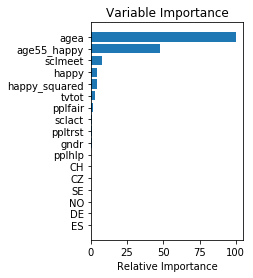

running rfc features for 20 times
params = 3


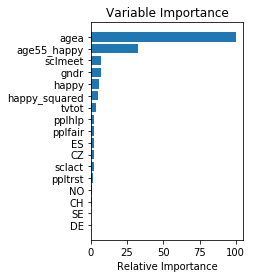

running rfc features for 20 times
params = 4


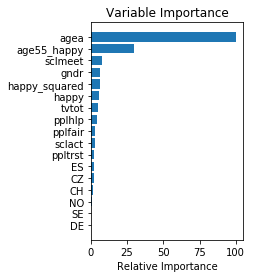

running rfc features for 20 times
params = 5


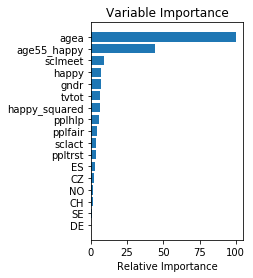

running rfc features for 20 times
params = 6


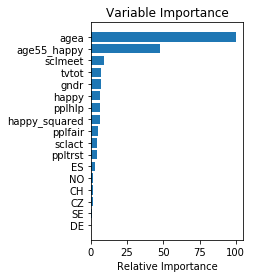

running rfc features for 20 times
params = 7


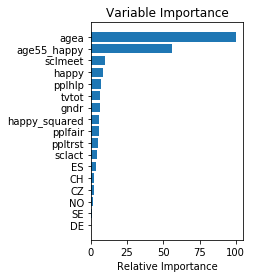

running rfc features for 20 times
params = 8


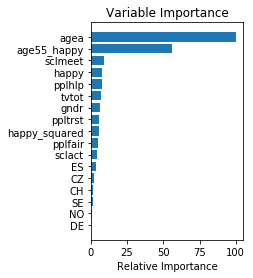

running rfc features for 20 times
params = 9


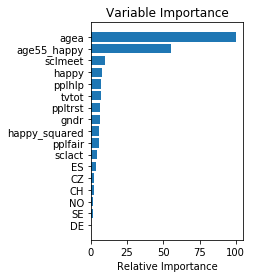

running rfc features for 20 times
params = 10


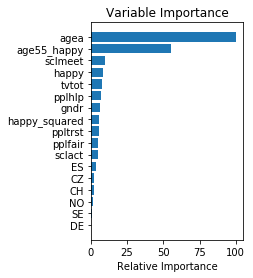

running rfc features for 20 times
params = 11


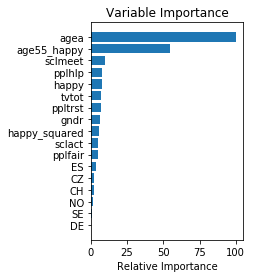

running rfc features for 20 times
params = 12


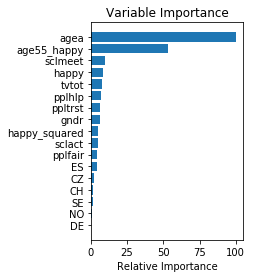

running rfc features for 20 times
params = 13


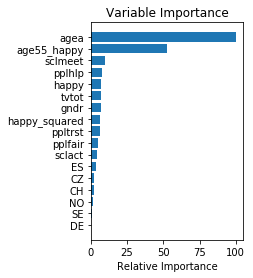

running rfc features for 20 times
params = 14


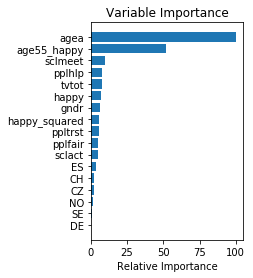

running rfc features for 20 times
params = 15


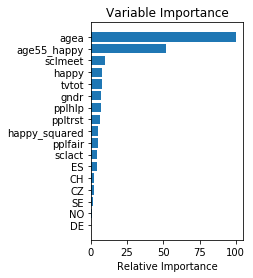

running rfc features for 20 times
params = 16


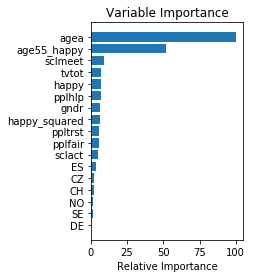

running rfc features for 20 times
params = 17


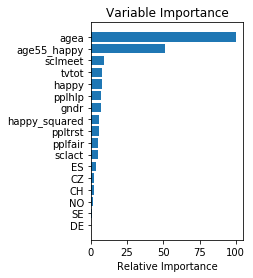

running rfc features for 20 times
params = 18


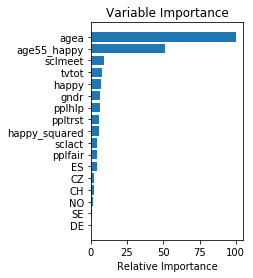

running rfc features for 20 times
params = 19


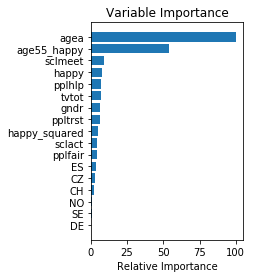

important_features: ['agea', 'age55_happy', 'sclmeet', 'happy', 'happy_squared', 'tvtot', 'pplfair', 'sclact', 'ppltrst', 'gndr', 'pplhlp', 'CH', 'CZ', 'SE', 'NO', 'DE', 'ES', '2']
important_features: ['agea', 'age55_happy', 'sclmeet', 'gndr', 'happy', 'happy_squared', 'tvtot', 'pplhlp', 'pplfair', 'ES', 'CZ', 'sclact', 'ppltrst', 'NO', 'CH', 'SE', 'DE', '3']
important_features: ['agea', 'age55_happy', 'sclmeet', 'gndr', 'happy_squared', 'happy', 'tvtot', 'pplhlp', 'pplfair', 'sclact', 'ppltrst', 'ES', 'CZ', 'CH', 'NO', 'SE', 'DE', '4']
important_features: ['agea', 'age55_happy', 'sclmeet', 'happy', 'gndr', 'tvtot', 'happy_squared', 'pplhlp', 'pplfair', 'sclact', 'ppltrst', 'ES', 'CZ', 'NO', 'CH', 'SE', 'DE', '5']
important_features: ['agea', 'age55_happy', 'sclmeet', 'tvtot', 'gndr', 'happy', 'pplhlp', 'happy_squared', 'pplfair', 'sclact', 'ppltrst', 'ES', 'NO', 'CH', 'CZ', 'SE', 'DE', '6']
important_features: ['agea', 'age55_happy', 'sclmeet', 'happy', 'pplhlp', 'tvtot', 'gndr', 'hap

In [37]:
max_items = 20
all_feature_important_columns = []

for i in range(2,max_items):
    print('running rfc features for {} times'.format(max_items))
    
    print("params = {}".format(i))
    columns2 = rfc_and_feature_importances(i)
    columns2.extend('{}'.format(i))
#     print("columns2 = {}".format(columns2))
    all_feature_important_columns.append(columns2)
#     print("all_feature_import_columns={}".format(all_feature_important_columns))
    
for list1 in all_feature_important_columns:
    print("important_features: {}".format(list1))